[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/carnotresearch/cr-sparse-evaluation/blob/master/comparison/pylops/image_deblurring.ipynb)


In [1]:
!python -m pip install --quiet pylops scikit-image git+https://github.com/carnotresearch/cr-sparse.git

     |████████████████████████████████| 180 kB 12.7 MB/s 
     |████████████████████████████████| 57 kB 6.1 MB/s 


In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
import pylops
import numpy as np
import jax.numpy as jnp
from cr.sparse import lop
import cr.sparse as crs
import cr.sparse.vision as vision
import cr.sparse.sls as sls
import cr.sparse.geo as geo
from cr.sparse import metrics
import skimage.data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
h_jax  = vision.kernel_gaussian((15,25), (8,4))
h_np = np.array(h_jax)

(-0.5, 24.5, 14.5, -0.5)

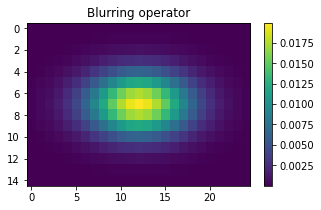

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h_jax)
ax.set_title('Blurring operator')
fig.colorbar(him, ax=ax)
ax.axis('tight')

In [7]:
offset = crs.arr_largest_index(h_jax)
offset

(DeviceArray(7, dtype=int64), DeviceArray(12, dtype=int64))

(500, 480)

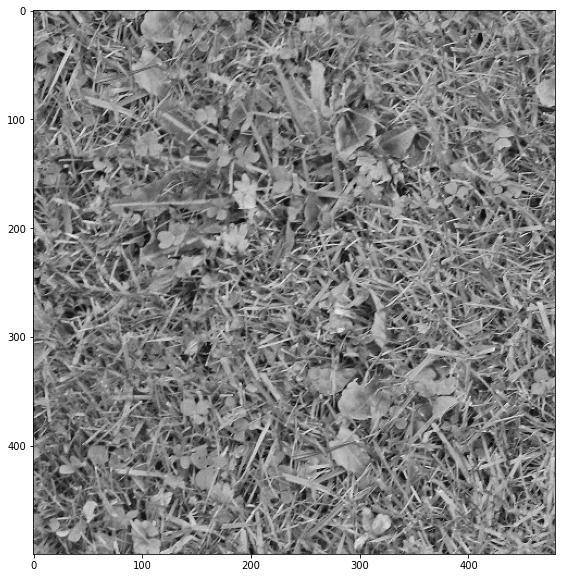

In [8]:
image_np = skimage.data.grass()
# cut the image a little bit to make use of padding later
image_np = image_np[:500, :480]
image_jax = jnp.array(image_np)
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image_np, cmap=plt.cm.gray)
image_np.shape

In [9]:
# The blur operator using CR-Sparse
Blur_jax = lop.convolve2D(image_jax.shape, h_jax, offset=offset)
Blur_jax = lop.jit(Blur_jax)

In [10]:
Blur_np = pylops.signalprocessing.Convolve2D(image_np.size, h_np, dims=image_np.shape, offset=offset)


In [11]:
blurred_np = Blur_np.matvec(image_np.flatten()).reshape(image_np.shape)

In [12]:
blurred_jax = Blur_jax.times(image_jax)

In [13]:
np.allclose(blurred_np, blurred_jax)

True

In [14]:
blur_np_time = %timeit -o Blur_np.matvec(image_np.flatten()).reshape(image_np.shape)

100 loops, best of 5: 15.3 ms per loop


In [15]:
blur_jax_time = %timeit -o Blur_jax.times(image_jax)

100 loops, best of 5: 14.3 ms per loop


In [16]:
gain = blur_np_time.best / blur_jax_time.best
print(gain)

1.069349625975225


In [17]:
print(metrics.peak_signal_noise_ratio(image_jax, blurred_jax), 'dB')

18.43464314401944 dB


Text(0.5, 1.0, 'After blurring')

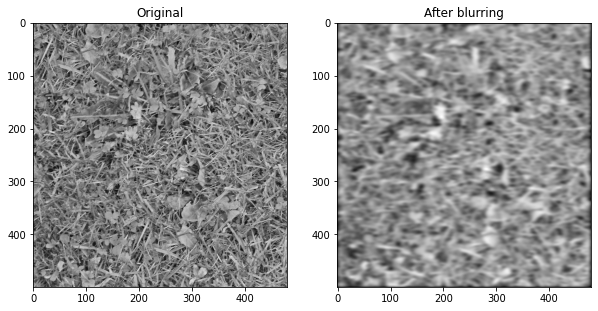

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image_jax, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(blurred_jax, cmap=plt.cm.gray)
ax[1].set_title('After blurring')

In [19]:
x0 = jnp.zeros_like(blurred_jax)
sol = sls.lsqr_jit(Blur_jax, blurred_jax, x0, max_iters=11)
deblurred_jax = sol.x
print(metrics.peak_signal_noise_ratio(image_jax, deblurred_jax), 'dB')

19.79312598449172 dB


In [20]:
print(sol)

x: (500, 480)
A_norm: 2.369799334421989
A_cond: 16.592094521926093
x_norm: 59387.28250150717
r_norm: 390.6092200111112
atr_norm: 93.52089514863766
iterations: 11
n_times: 11
n_trans: 11


Text(0.5, 1.0, 'After deblurring')

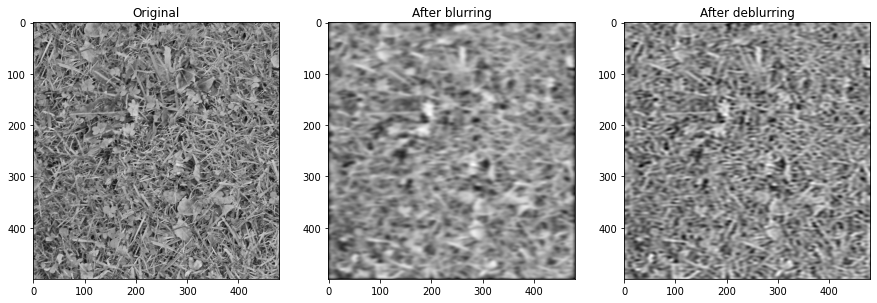

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(image_jax, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(blurred_jax, cmap=plt.cm.gray)
ax[1].set_title('After blurring')
ax[2].imshow(deblurred_jax, cmap=plt.cm.gray)
ax[2].set_title('After deblurring')

In [22]:
x0_np = np.array(x0).flatten()
result_np = pylops.optimization.solver.lsqr(Blur_np, blurred_np.flatten(), x0_np, niter=10)
x, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var, cost= result_np
print(f'itn={itn} \n')
deblurred_np = x.reshape(image_np.shape)
print(metrics.peak_signal_noise_ratio(image_np, deblurred_np), 'dB')

itn=10 

19.79312598449172 dB


In [23]:
np.allclose(deblurred_np, deblurred_jax)

True

In [24]:
lsqr_np_time = %timeit -o pylops.optimization.solver.lsqr(Blur_np, blurred_np.flatten(), x0_np, niter=10)

1 loop, best of 5: 623 ms per loop


In [25]:
lsqr_jax_time = %timeit -o sls.lsqr_jit(Blur_jax, blurred_jax, x0, max_iters=11)

1 loop, best of 5: 336 ms per loop


In [26]:
gain = lsqr_np_time.best / lsqr_jax_time.best
print(gain)

1.8554177626509707
